In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

In [3]:
stock_df = pd.read_csv('bgd-ndvi-adm2-5ytd_2022.csv')
stock_df

,date,vim,vim_avg,viq
0,01/01/2022,0.4822,0.4388,108.8817
1,01/01/2022,0.4988,0.4615,107.2895
2,01/01/2022,0.5526,0.5154,106.5656
3,01/01/2022,0.4480,0.3724,117.9170
4,01/01/2022,0.5010,0.5051,99.2619
...,...,...,...,...
2335,21/12/2022,0.4873,0.4339,111.0509
2336,21/12/2022,0.3456,0.3455,100.0223
2337,21/12/2022,0.4838,0.4672,103.2018
2338,21/12/2022,0.5491,0.4947,109.9815


In [4]:
stock_df['date']=pd.to_datetime(stock_df['date'], format='%d/%m/%Y')

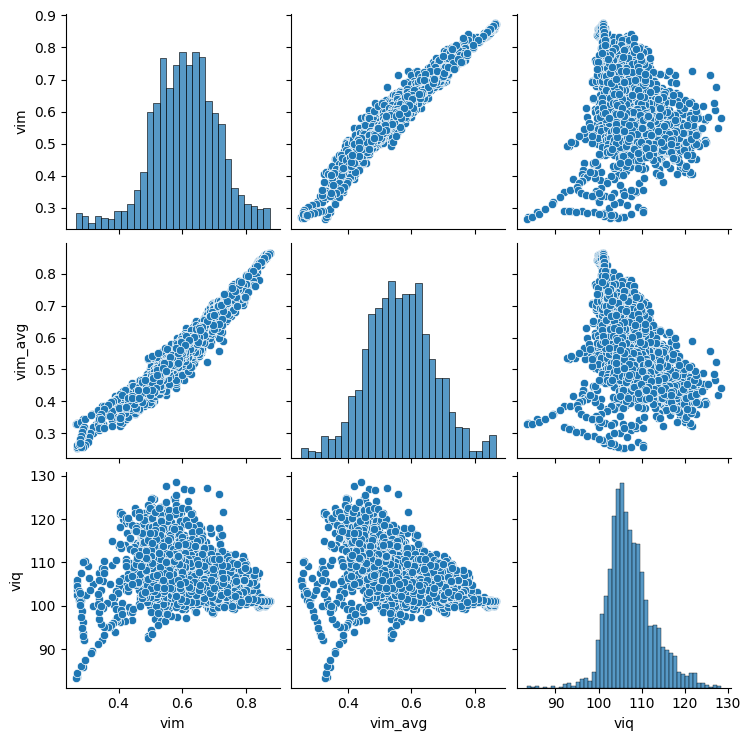

In [6]:
sns.pairplot(stock_df)

In [7]:
stock_df.describe().round(2)

,date,vim,vim_avg,viq
count,2340,2340.00,2340.00,2340.00
mean,2022-06-26 12:00:00,0.61,0.56,107.38
min,2022-01-01 00:00:00,0.27,0.25,83.38
25%,2022-03-29 06:00:00,0.54,0.49,103.95
50%,2022-06-26 00:00:00,0.61,0.56,106.58
75%,2022-09-23 12:00:00,0.68,0.63,110.18
max,2022-12-21 00:00:00,0.88,0.87,128.45
std,NaN,0.11,0.11,5.38


In [8]:
ndvi_data = stock_df['date'].values

In [9]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
ndvi_data = scaler.fit_transform(ndvi_data.reshape(-1, 1))

In [10]:
# Define the sequence length (number of time steps) and split the data into input and target sequences
sequence_length = 10  # You can adjust this to your needs
X, y = [], []
for i in range(len(ndvi_data) - sequence_length):
    X.append(ndvi_data[i:i+sequence_length])
    y.append(ndvi_data[i+sequence_length])

X, y = np.array(X), np.array(y)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Create a Decision Tree regressor
decision_tree = DecisionTreeRegressor()

In [13]:
# Create an LSTM model for feature extraction
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)

# Extract features using the LSTM model
features_train = lstm_model.predict(X_train)
features_test = lstm_model.predict(X_test)

Epoch 1/50
59/59 [==============================] - 1s 3ms/step - loss: 0.1872
Epoch 2/50
59/59 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 3/50
59/59 [==============================] - 0s 3ms/step - loss: 1.6520e-04
Epoch 4/50
59/59 [==============================] - 0s 4ms/step - loss: 9.3886e-05
Epoch 5/50
59/59 [==============================] - 0s 3ms/step - loss: 7.4310e-05
Epoch 6/50
59/59 [==============================] - 0s 3ms/step - loss: 6.1039e-05
Epoch 7/50
59/59 [==============================] - 0s 3ms/step - loss: 5.4710e-05
Epoch 8/50
59/59 [==============================] - 0s 3ms/step - loss: 5.4099e-05
Epoch 9/50
59/59 [==============================] - 0s 3ms/step - loss: 5.0060e-05
Epoch 10/50
59/59 [==============================] - 0s 3ms/step - loss: 4.7420e-05
Epoch 11/50
59/59 [==============================] - 0s 3ms/step - loss: 4.6549e-05
Epoch 12/50
59/59 [==============================] - 0s 3ms/step - loss: 4.4701e-05
Epoch 13/

In [14]:
# Create an SVR model for regression
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Train the SVR model using the extracted features
svr_model.fit(features_train, y_train)


e:\Python\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(epsilon=0.2)

In [15]:
# Create a Voting Regressor ensemble with the Decision Tree and SVR
ensemble = VotingRegressor(estimators=[('decision_tree', decision_tree), ('svr', svr_model)])

In [16]:
# Train the ensemble model
ensemble.fit(features_train, y_train)

e:\Python\lib\site-packages\sklearn\ensemble\_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('decision_tree', DecisionTreeRegressor()),
                            ('svr', SVR(epsilon=0.2))])

In [17]:
# Make predictions with the ensemble
y_pred = ensemble.predict(features_test)

In [18]:
# Inverse transform the predictions and true values to the original scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

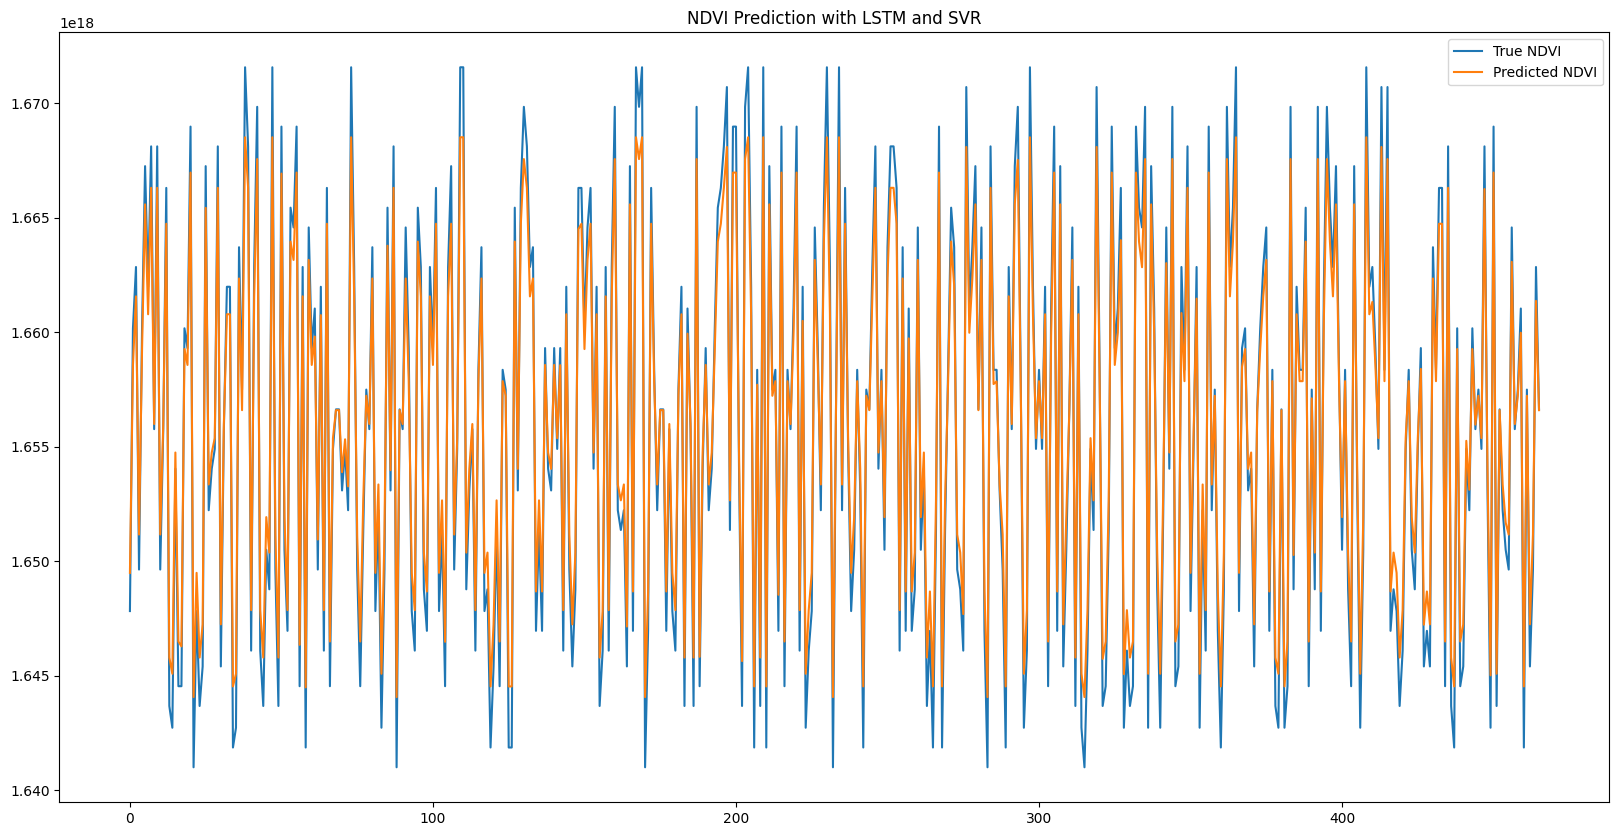

In [21]:
# Plot the results
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='True NDVI')
plt.plot(y_pred, label='Predicted NDVI')
plt.legend()
plt.title('NDVI Prediction with LSTM and SVR')
plt.show()